In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ptb-ecg-database/README.md
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/RECORDS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/README
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/CONTROLS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/ptb.png
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0029lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-dat

In [2]:
import os
import pandas as pd
import numpy as np
import re

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
os.system('pip install PyWavelets')
import pywt

In [5]:
os.system('pip install wfdb')
import wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:00


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

---

# **EDA**
Here we analyze the data.

In [7]:
def list_subdirectories(path):
    try:
        if not os.path.isdir(path):
            print(f"Error: The path '{path}' is not a valid directory.")
            return None

        entries = os.listdir(path)
        subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
        subdirectories.sort()
        
        return subdirectories

    except FileNotFoundError:
        print(f"Error: The path '{path}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to access '{path}'.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [8]:
path = "/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0"
subdirectories = list_subdirectories(path)
patients = pd.DataFrame(subdirectories)
patients

,0
0,patient001
1,patient002
2,patient003
3,patient004
4,patient005
...,...
285,patient290
286,patient291
287,patient292
288,patient293


In [9]:
def find_hea_files_in_subdirs(base_path):
    
    subdirs = list_subdirectories(base_path)
    if subdirs is None:
        return None

    hea_files_by_dir = {}

    for subdir in subdirs:
        try:
            subdir_path = os.path.join(base_path, subdir)
            all_files = os.listdir(subdir_path)
            
            hea_files = [f for f in all_files if f.endswith('.hea') and os.path.isfile(os.path.join(subdir_path, f))]
            hea_files.sort()
            
            hea_files_by_dir[subdir] = hea_files
        except PermissionError:
            print(f"Warning: Permission denied for directory '{subdir}'. Skipping.")
            hea_files_by_dir[subdir] = ["--> Permission Denied"]
        except Exception as e:
            print(f"Warning: Could not process directory '{subdir}': {e}. Skipping.")
            hea_files_by_dir[subdir] = [f"--> Error: {e}"]
            
    return hea_files_by_dir

In [10]:
patients_header = find_hea_files_in_subdirs(path)
patients_header

{'patient001': ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'],
 'patient002': ['s0015lre.hea'],
 'patient003': ['s0017lre.hea'],
 'patient004': ['s0020are.hea', 's0020bre.hea'],
 'patient005': ['s0021are.hea',
  's0021bre.hea',
  's0025lre.hea',
  's0031lre.hea',
  's0101lre.hea'],
 'patient006': ['s0022lre.hea', 's0027lre.hea', 's0064lre.hea'],
 'patient007': ['s0026lre.hea',
  's0029lre.hea',
  's0038lre.hea',
  's0078lre.hea'],
 'patient008': ['s0028lre.hea', 's0037lre.hea', 's0068lre.hea'],
 'patient009': ['s0035_re.hea'],
 'patient010': ['s0036lre.hea', 's0042lre.hea', 's0061lre.hea'],
 'patient011': ['s0039lre.hea',
  's0044lre.hea',
  's0049lre.hea',
  's0067lre.hea'],
 'patient012': ['s0043lre.hea', 's0050lre.hea'],
 'patient013': ['s0045lre.hea', 's0051lre.hea', 's0072lre.hea'],
 'patient014': ['s0046lre.hea', 's0056lre.hea', 's0071lre.hea'],
 'patient015': ['s0047lre.hea', 's0057lre.hea', 's0152lre.hea'],
 'patient016': ['s0052lre.hea', 's0060lre.hea', 's0076lre.hea'],
 'pa

In [11]:
def extract_localization_from_files(hea_data, base_path):
    
    data_by_patient = {}
    
    if not hea_data:
        return {}

    for directory, file_list in hea_data.items():
        
        grouped_by_info = {}

        for file_name in file_list:
            full_path = os.path.join(base_path, directory, file_name)
            
            acute_loc = "Not specified"
            former_loc = "Not specified"
            disease = "Not specified"
            age = "Not specified"
            sex = "Not specified"
            smoker = "Not specified"
            vessels = "Not specified"
            additional_diagnoses = "Not specified"


            if file_name.startswith("-->"):
                
                acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = ["N/A (Previous error)"] * 8
            else:
                try:
                    with open(full_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        
                        # Extract all fields using regex
                        acute_match = re.search(r'# Acute infarction \(localization\): (.*)', content)
                        if acute_match: acute_loc = acute_match.group(1).strip()
                        
                        former_match = re.search(r'# Former infarction \(localization\): (.*)', content)
                        if former_match: former_loc = former_match.group(1).strip()
                        
                        dis_match = re.search(r'# Reason for admission: (.*)', content)
                        if dis_match: disease = dis_match.group(1).strip()

                        age_match = re.search(r'# age: (.*)', content)
                        if age_match: age = age_match.group(1).strip()

                        sex_match = re.search(r'# sex: (.*)', content)
                        if sex_match: sex = sex_match.group(1).strip()

                        smoker_match = re.search(r'# Smoker: (.*)', content)
                        if smoker_match: smoker = smoker_match.group(1).strip()

                        vessels_match = re.search(r'# Number of coronary vessels involved: (.*)', content)
                        if vessels_match: vessels = vessels_match.group(1).strip()

                        additional_dx_match = re.search(r'# Additional diagnoses: (.*)', content)
                        if additional_dx_match: additional_diagnoses = additional_dx_match.group(1).strip()

                except Exception as e:
                    acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = [f"--> Error: {e}"] * 8
            
            info_tuple = (acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses)
            if info_tuple not in grouped_by_info:
                grouped_by_info[info_tuple] = []
            grouped_by_info[info_tuple].append(file_name)
        
        patient_summary_list = []
        for info, files in grouped_by_info.items():
            
            unpacked_info = info
            patient_summary_list.append(unpacked_info + (len(files), files))
            
        data_by_patient[directory] = patient_summary_list
            
    return data_by_patient

In [12]:
patients_localization = extract_localization_from_files(patients_header,path)
patients_localization

{'patient001': [('infero-latera',
   'no',
   'Myocardial infarction',
   '81',
   'female',
   'no',
   '1',
   'Diabetes mellitus',
   3,
   ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'])],
 'patient002': [('anterior',
   'no',
   'Myocardial infarction',
   '58',
   'female',
   'yes',
   '1',
   'Arterial hypertension, Adiposis hepatis, Gastritis',
   1,
   ['s0015lre.hea'])],
 'patient003': [('infero-postero-lateral',
   'no',
   'Myocardial infarction',
   '63',
   'male',
   'yes',
   '1',
   'no',
   1,
   ['s0017lre.hea'])],
 'patient004': [('antero-septal',
   'no',
   'Myocardial infarction',
   '69',
   'male',
   'no',
   '1',
   'Arterial hypertension, Obesity',
   2,
   ['s0020are.hea', 's0020bre.hea'])],
 'patient005': [('anterior',
   'no',
   'Myocardial infarction',
   '74',
   'male',
   'no',
   '2',
   'Skoliosis',
   5,
   ['s0021are.hea',
    's0021bre.hea',
    's0025lre.hea',
    's0031lre.hea',
    's0101lre.hea'])],
 'patient006': [('anterior',
   'inferi

In [13]:
def convert_to_dataframe(patient_data):
    
    try:
        import pandas as pd
    except ImportError:
        return None

    data_for_df = []
    for patient, summary_list in patient_data.items():
        if summary_list:
            for data_tuple in summary_list:
                (acute_loc, former_loc, disease, age, sex, smoker, 
                 vessels, additional_diagnoses, count, files) = data_tuple
                
                data_for_df.append({
                    'patient': patient,
                    'age': age,
                    'sex': sex,
                    'disease': disease,
                    'acute_localization': acute_loc,
                    'former_localization': former_loc,
                    'additional_diagnoses': additional_diagnoses,
                    'smoker': smoker,
                    'vessels_involved': vessels,
                    'file_count': count,
                    'hea_files': ", ".join(files)
                })
        else:
            data_for_df.append({
                'patient': patient,
                'age': 'N/A',
                'sex': 'N/A',
                'disease': 'N/A',
                'acute_localization': 'N/A',
                'former_localization': 'N/A',
                'additional_diagnoses': 'N/A',
                'smoker': 'N/A',
                'vessels_involved': 'N/A',
                'file_count': 0,
                'hea_files': ''
            })

    return pd.DataFrame(data_for_df)

In [14]:
patient_details = convert_to_dataframe(patients_localization)
patient_details.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,smoker,vessels_involved,file_count,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,no,1,3,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",yes,1,1,s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,yes,1,1,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity",no,1,2,"s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,no,2,5,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [15]:
patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/patient_details.shape[0] * 100

patient                  0.000000
age                      5.172414
sex                      3.103448
disease                  7.586207
acute_localization      56.206897
former_localization     84.137931
additional_diagnoses    40.689655
smoker                  74.827586
vessels_involved        54.482759
file_count               0.000000
hea_files                0.000000
dtype: float64

Dealing with **disease** data imbalance.

In [16]:
patient_detail = patient_details.drop(columns=['vessels_involved','file_count','smoker'])
final_patient_details = patient_detail.copy()
final_patient_details.loc[~final_patient_details['disease'].isin(["Myocardial infarction", "Healthy control"]), 'disease'] = 'other'
final_patient_details

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."
...,...,...,...,...,...,...,...,...
285,patient290,60,male,Myocardial infarction,antero-septal,inferior,unknown,s0553_re.hea
286,patient291,69,male,Myocardial infarction,inferior,inferior,unknown,s0554_re.hea
287,patient292,66,male,Myocardial infarction,antero-lateral,no,Arterial hypertension,"s0555_re.hea, s0556_re.hea"
288,patient293,75,male,Myocardial infarction,antero-lateral,no,unknown,"s0557_re.hea, s0558_re.hea"


In [17]:
final_patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/final_patient_details.shape[0] * 100

patient                  0.000000
age                      5.172414
sex                      3.103448
disease                  0.000000
acute_localization      56.206897
former_localization     84.137931
additional_diagnoses    40.689655
hea_files                0.000000
dtype: float64

In [18]:
patients = final_patient_details.replace('n/a', np.nan)

Dealing with **age** data imbalance.

In [19]:
patients['age'] = SimpleImputer(strategy='mean').fit_transform(patients[['age']])
patients

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."
...,...,...,...,...,...,...,...,...
285,patient290,60.0,male,Myocardial infarction,antero-septal,inferior,unknown,s0553_re.hea
286,patient291,69.0,male,Myocardial infarction,inferior,inferior,unknown,s0554_re.hea
287,patient292,66.0,male,Myocardial infarction,antero-lateral,no,Arterial hypertension,"s0555_re.hea, s0556_re.hea"
288,patient293,75.0,male,Myocardial infarction,antero-lateral,no,unknown,"s0557_re.hea, s0558_re.hea"


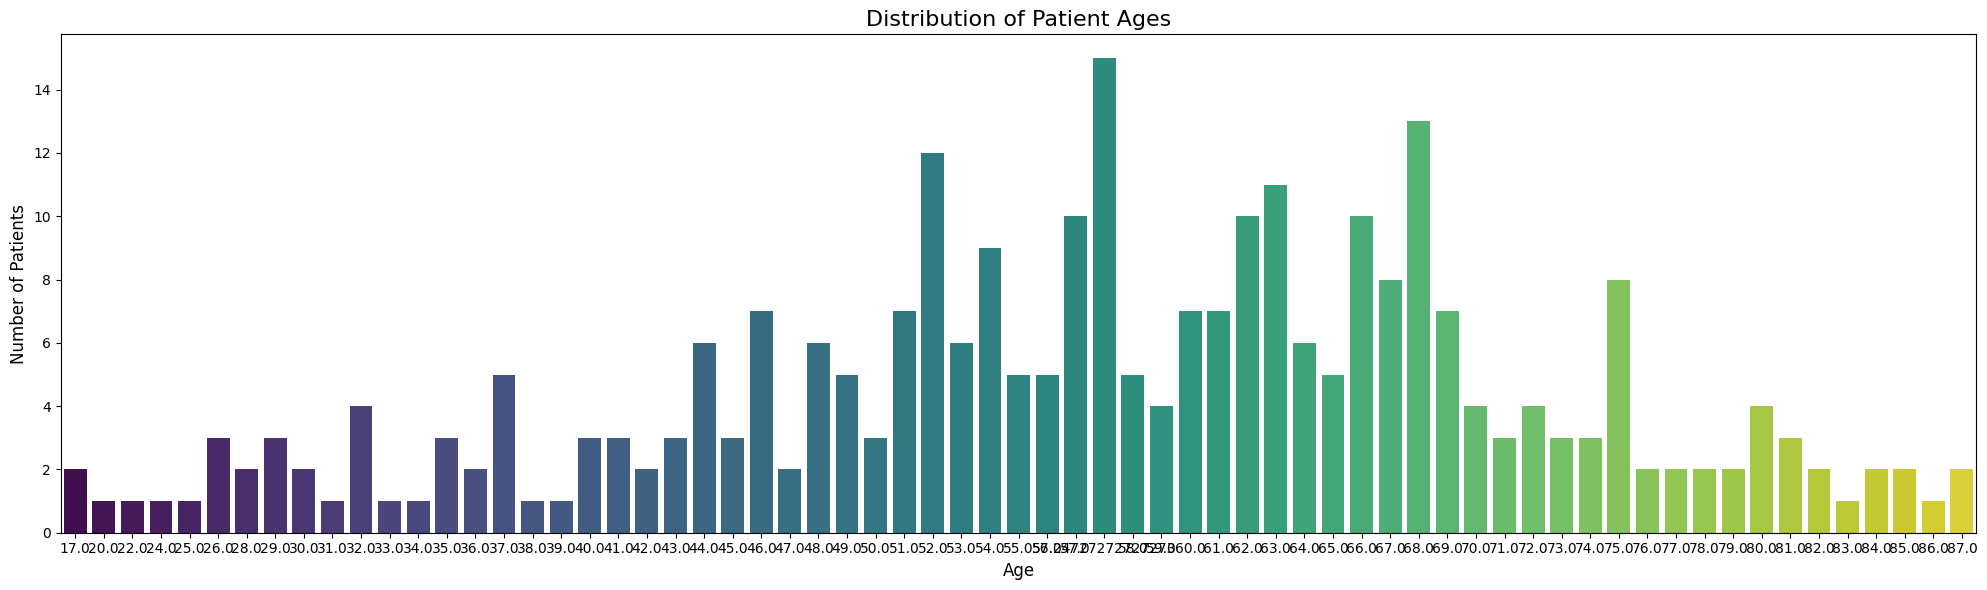

In [20]:
plt.figure(figsize=(20, 6))
sns.countplot(x='age', data=patients, palette='viridis')

plt.title('Distribution of Patient Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.tight_layout() # Adjust layout to make room for labels

plt.show()

Dealing with **sex** data imbalance.

In [21]:
patients.loc[~patients['sex'].isin(["male", "female"]), 'sex'] = 'other'

In [22]:
patients.sex.value_counts()

sex
male      200
female     81
other       9
Name: count, dtype: int64

Dealing with **acute_localization** data imbalance.

In [23]:
patients.acute_localization.value_counts()

acute_localization
no                        140
inferior                   30
antero-septal              27
infero-lateral             22
anterior                   17
antero-lateral             16
infero-postero-lateral      7
postero-lateral             2
infero-latera               1
infero-poster-lateral       1
lateral                     1
posterior                   1
infero-posterior            1
antero-septo-lateral        1
unknown                     1
Name: count, dtype: int64

In [24]:
localization_map = {
    'no': 'NO',
    'inferior': 'IMI',
    'antero-septal': 'ASMI',
    'infero-lateral': 'ILMI',
    'anterior': 'AMI',
    'antero-lateral': 'ALMI',
    'infero-postero-lateral': 'IPLMI',
    'postero-lateral': 'PLMI',
    'infero-latera': 'ILMI',
    'infero-poster-lateral': 'IPLMI',
    'lateral': 'LMI',
    'posterior': 'PMI',
    'infero-posterior': 'IPMI',
    'antero-septo-lateral': 'ASLMI',
    'unknown': np.nan
}

patients['acute_localization'] = patients['acute_localization'].str.strip().str.lower()
patients['acute_localization'] = patients['acute_localization'].replace(localization_map)
patients = patients.dropna(subset=['acute_localization'])
patients['acute_localization'].value_counts()

acute_localization
NO       140
IMI       30
ASMI      27
ILMI      23
AMI       17
ALMI      16
IPLMI      8
PLMI       2
LMI        1
PMI        1
IPMI       1
ASLMI      1
Name: count, dtype: int64

Dealing with **former_localization** data imbalance.

In [25]:
patients.former_localization.value_counts()

former_localization
no                                    209
anterior                               14
inferior                               13
unknown                                12
infero-posterior                        3
antero-lateral                          3
infero-lateral                          2
anterior (1), inferior (2)              2
antero-septal ?                         1
infero-posterior (1), inferior (2)      1
anterior ?                              1
infero-postero-lateral                  1
anterior (1), anterior (2)              1
inferior ?                              1
postero-lateral                         1
antero-septal                           1
inferior (1+2)                          1
Name: count, dtype: int64

In [26]:
localization_map = {
    'no': 'NO',
    'anterior': 'AMI',
    'inferior': 'IMI',
    'unknown' : np.nan,
    'infero-posterior': 'IPMI',
    'antero-lateral': 'ALMI',
    'infero-lateral': 'ILMI',
    'anterior (1), inferior (2)': 'AMI IMI',
    'antero-septal ?': 'ASMI',
    'infero-posterior (1), inferior (2)': 'IPMI IMI',
    'anterior ?': 'AMI',
    'infero-postero-lateral': 'IPMI',
    'anterior (1), anterior (2)': 'AMI',
    'inferior ?': 'IMI',
    'postero-lateral': 'PLMI',
    'antero-septal': 'ASMI',
    'inferior (1+2)': 'IMI'
}
patients = patients.copy()
patients['former_localization'] = patients['former_localization'].replace(localization_map)
patients['former_localization'] = patients['former_localization'].fillna("other")
patients['former_localization'].value_counts()

former_localization
NO          209
AMI          16
IMI          15
other        12
IPMI          4
ALMI          3
ASMI          2
ILMI          2
AMI IMI       2
PLMI          1
IPMI IMI      1
Name: count, dtype: int64

In [27]:
patients['former_localization'].isin([np.nan]).sum()

0

Dealing with **additional_diagnoses** data imbalance.

In [28]:
patients.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81.0,female,Myocardial infarction,ILMI,NO,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,AMI,NO,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,IPLMI,NO,no,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,ASMI,NO,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,AMI,NO,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [29]:
patients.additional_diagnoses.value_counts()

additional_diagnoses
no                                                                                       81
unknown                                                                                  14
Arterial hypertension                                                                    14
Hypercholesterinemia                                                                      5
Diabetes mellitus                                                                         4
                                                                                         ..
Arterial hypertension, Hypercholesterinemia, Chronic hepatitis                            1
Hyperlipoproteinemia Type IIb, Ventricular fibrillation                                   1
Hyperlipoproteinemia Type IIa, Diabetes mellitus, Renal insufficiency, Bladder cancer     1
M. Bechterew                                                                              1
Dilated Cardiomyopathy, Recurrent ventricular tachycardias 

Removing additional_diagnosis as the data is highly unique.

In [30]:
patients = patients.drop(columns=['additional_diagnoses'])
patients.head()

,patient,age,sex,disease,acute_localization,former_localization,hea_files
0,patient001,81.0,female,Myocardial infarction,ILMI,NO,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,AMI,NO,s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,IPLMI,NO,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,ASMI,NO,"s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,AMI,NO,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


---

# **Preprocessing**
## *Demonstrating the preprocessing steps for one patient.*

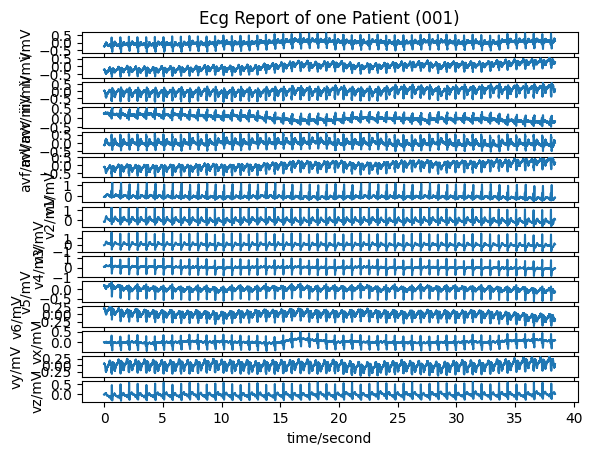

In [31]:
record = wfdb.rdrecord('/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re') 
wfdb.plot_wfdb(record=record, title='Ecg Report of one Patient (001)') 

## *Using only lead (II and III)*

In [32]:
signals, fields = wfdb.rdsamp('/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', channels=[1,2])
raw_ecg_data = pd.DataFrame(signals, columns=['lead_ii', 'lead_iii'])
print("Successfully loaded the ECG signal data.")
raw_ecg_data

Successfully loaded the ECG signal data.


,lead_ii,lead_iii
0,-0.2290,0.0155
1,-0.2335,0.0090
2,-0.2345,0.0070
3,-0.2290,0.0120
4,-0.2270,0.0045
...,...,...
38395,0.2510,0.1125
38396,0.2590,0.1100
38397,0.2695,0.1180
38398,0.2560,0.1205


## *Using DWT to Filter Out the Frequencies*

We use **level = 9**, as for **fs = 1000 Hz**, we need to go up to level 9 to isolate the **< 0.5 Hz** band.

#### Frequency Bands for fs = 1000 Hz (approximate)

- **cA9:** 0 – 0.97 Hz → Contains baseline wander (< 0.5 Hz)  
- **cD9:** 0.97 – 1.95 Hz  
- **cD8:** 1.95 – 3.9 Hz  
- **cD7:** 3.9 – 7.8 Hz  
- **cD6:** 7.8 – 15.6 Hz
<br> **------------------ Cutoff is here (≈ 15.6 Hz) ------------------**  
- **cD5:** 15.6 – 31.25 Hz  
- **cD4:** 31.25 – 62.5 Hz  
- **cD3:** 62.5 – 125 Hz  
- **cD2:** 125 – 250 Hz  
- **cD1:** 250 – 500 Hz  


In [33]:
def denoise_signal_dwt(signal, fs):
    
    wavelet = 'db6'
    level = 9
    
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    coeffs[0] = np.zeros_like(coeffs[0])  # Remove cA9 (< 0.97 Hz)
    coeffs[-1] = np.zeros_like(coeffs[-1]) # Remove cD1 (> 250 Hz)
    coeffs[-2] = np.zeros_like(coeffs[-2]) # Remove cD2 (> 125 Hz)
    coeffs[-3] = np.zeros_like(coeffs[-3]) # Remove cD3 (> 62.5 Hz)
    coeffs[-4] = np.zeros_like(coeffs[-4]) # Remove cD4 (> 31.25 Hz)
    coeffs[-5] = np.zeros_like(coeffs[-5]) # Remove cD5 (> 15.6 Hz)
    
    denoised_signal = pywt.waverec(coeffs, wavelet)
    denoised_signal = np.pad(denoised_signal, (0, len(signal) - len(denoised_signal)), 'edge')

    return denoised_signal

Denoising signals using DWT...
Plotting a sample of the denoising effect for Lead II...


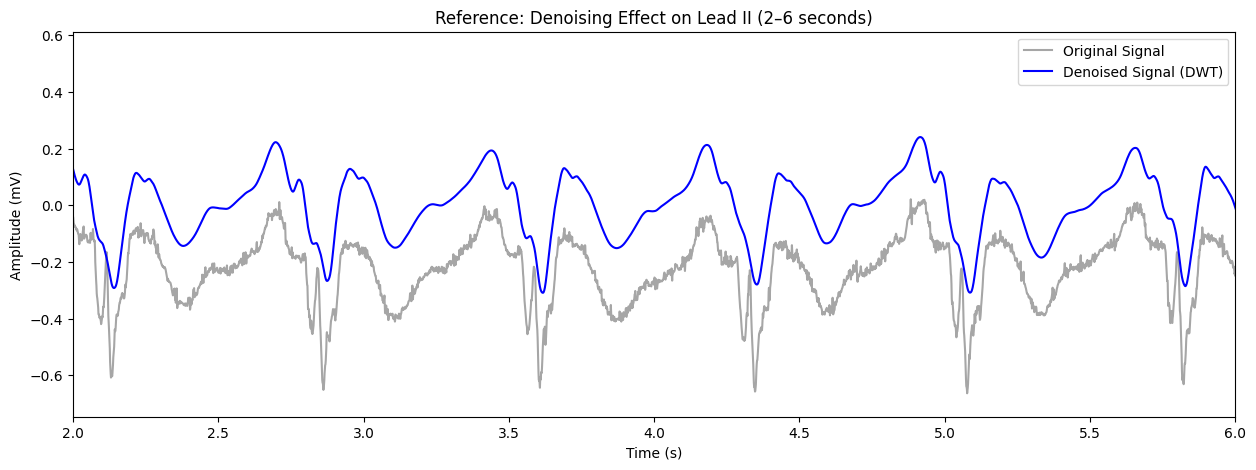

Plotting a sample of the denoising effect for Lead III...


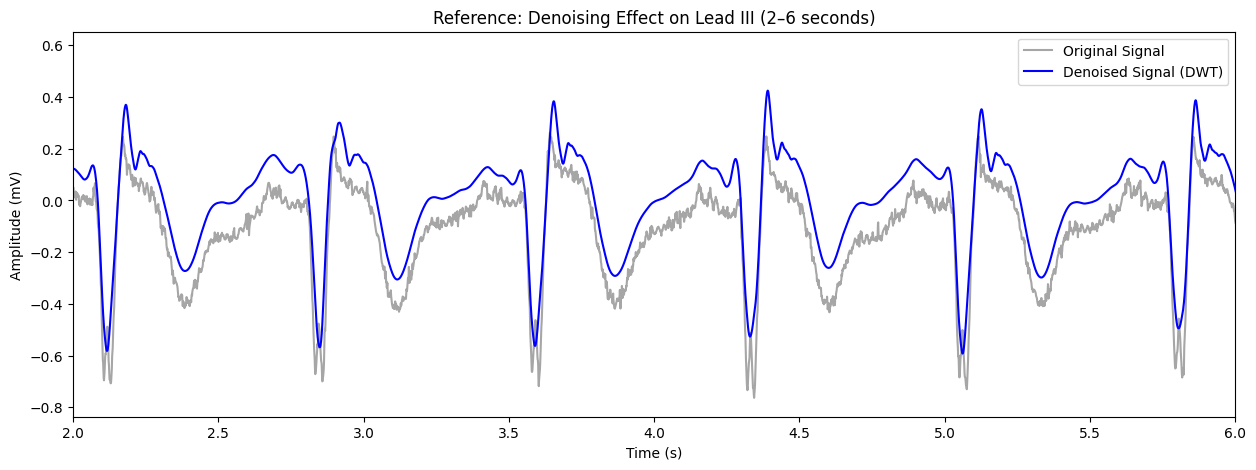

In [34]:
fs = fields['fs']

signal_lead_ii = pd.Series(signals[:, 0]).bfill().values
signal_lead_iii = pd.Series(signals[:, 1]).bfill().values

print("Denoising signals using DWT...")
denoised_lead_ii = denoise_signal_dwt(signal_lead_ii, fs)
denoised_lead_iii = denoise_signal_dwt(signal_lead_iii, fs)

# Plot Lead II
print("Plotting a sample of the denoising effect for Lead II...")
plt.figure(figsize=(15, 5))
plt.title("Reference: Denoising Effect on Lead II (2–6 seconds)")
time_ref = np.arange(len(signal_lead_ii)) / fs
plt.plot(time_ref, signal_lead_ii, 'gray', alpha=0.7, label='Original Signal')
plt.plot(time_ref, denoised_lead_ii, 'b', label='Denoised Signal (DWT)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(2, 6)
plt.legend()
plt.show()

# Plot Lead III
print("Plotting a sample of the denoising effect for Lead III...")
plt.figure(figsize=(15, 5))
plt.title("Reference: Denoising Effect on Lead III (2–6 seconds)")
time_ref = np.arange(len(signal_lead_iii)) / fs
plt.plot(time_ref, signal_lead_iii, 'gray', alpha=0.7, label='Original Signal')
plt.plot(time_ref, denoised_lead_iii, 'b', label='Denoised Signal (DWT)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(2, 6)
plt.legend()
plt.show()


## *Here we apply Pan Tompkins Detector Algorithm.*

In [35]:
def pan_tompkins_detector(signal, fs):
    
    # Stages 2-5 of Pan-Tompkins: Derivative, Squaring, Integration, Thresholding
    derivative_signal = np.diff(signal) * fs
    derivative_signal = np.append(derivative_signal, derivative_signal[-1])
    squared_signal = derivative_signal**2
    window_size = int(0.150 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')
    
    # r_peaks = []
    # noise_peak = np.mean(integrated_signal[:int(2*fs)])
    # signal_peak = np.max(integrated_signal[:int(2*fs)])
    # threshold = noise_peak + 0.25 * (signal_peak - noise_peak)
    # min_rr_interval = int(0.2 * fs)
    # last_r_peak_sample = -min_rr_interval
    
    # for i in range(1, len(integrated_signal) - 1):
    #     if integrated_signal[i] > integrated_signal[i-1] and integrated_signal[i] > integrated_signal[i+1]:
    #         peak_sample = i
    #         peak_value = integrated_signal[peak_sample]
    #         if peak_value > threshold:
    #             if (peak_sample - last_r_peak_sample) > min_rr_interval:
    #                 r_peaks.append(peak_sample)
    #                 last_r_peak_sample = peak_sample
    #                 signal_peak = 0.125 * peak_value + 0.875 * signal_peak
    #         else:
    #             noise_peak = 0.125 * peak_value + 0.875 * noise_peak
    #         threshold = noise_peak + 0.25 * (signal_peak - noise_peak)
            
    return integrated_signal


Detecting R-peaks from Lead II...

Plotting a comparison of the Denoised vs. Integrated signal...


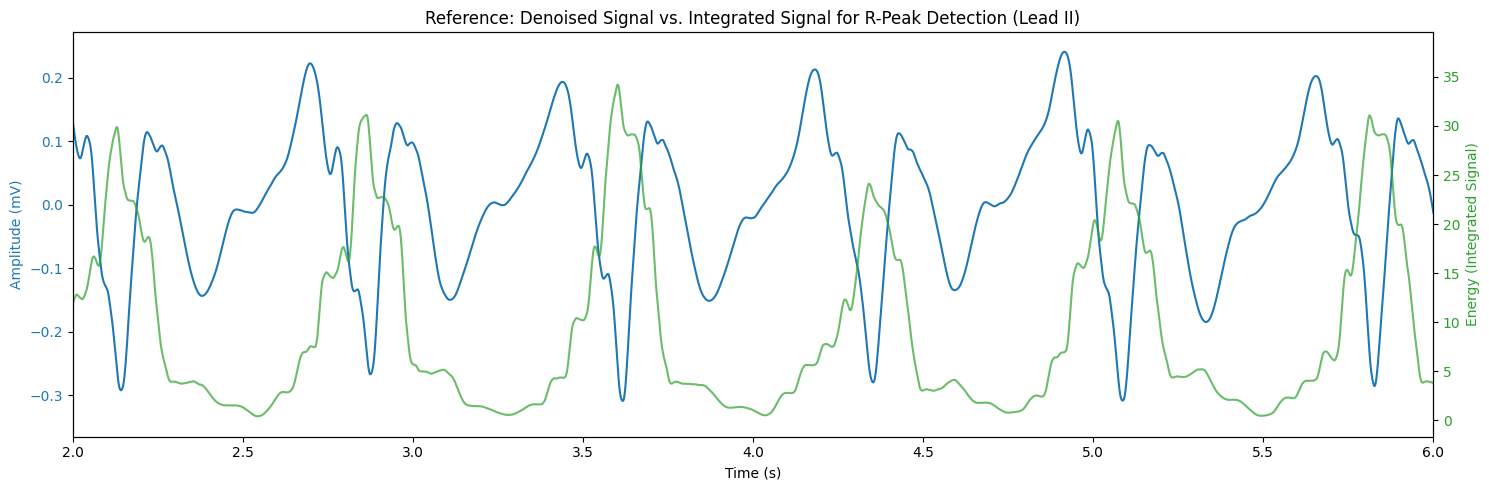

In [36]:
print("\nDetecting R-peaks from Lead II...")
integrated_signal_ii = pan_tompkins_detector(denoised_lead_ii, fs)
# print(f"Found {len(r_peaks_ii)} R-peaks.")

# --- ADDED: PLOT DENOISED VS INTEGRATED SIGNAL ---
print("\nPlotting a comparison of the Denoised vs. Integrated signal...")
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.title("Reference: Denoised Signal vs. Integrated Signal for R-Peak Detection (Lead II)")
time_vec = np.arange(len(denoised_lead_ii)) / fs

# Plot Denoised Signal on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (mV)', color=color)
ax1.plot(time_vec, denoised_lead_ii, color=color, label='Denoised Signal')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(2, 6)

# Create a second y-axis for the Integrated Signal
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Energy (Integrated Signal)', color=color)
ax2.plot(time_vec, integrated_signal_ii, color=color, label='Integrated Signal', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
# --- END OF ADDED PLOT ---

In [37]:
denoised_lead_ii.shape

(38400,)

In [38]:
samples_5s = fields['fs'] * 5
divisions = fields['sig_len']/samples_5s
print(samples_5s,divisions)

5000 7.68


In [39]:
def load_ptb_ecg(base_path, patients):

    all_segments = []

    for index, row in patients.iterrows():
        patient_id = row['patient']
        hea_files_string = row['hea_files']
        file_list = hea_files_string.split(',')

        print(f"Processing records for: {patient_id}")

        for filename in file_list:
            record_name = filename.strip().replace('.hea', '')
            record_path = os.path.join(base_path, patient_id, record_name)

            try:
                signals, fields = wfdb.rdsamp(record_path, channels=[0, 1])

                fs = fields['fs']
                sig_len = fields['sig_len']
                samples_5s = int(fs * 5)
                divisions = sig_len / samples_5s

                total_needed = int(np.ceil(divisions) * samples_5s)
                if total_needed > sig_len:
                    pad_len = total_needed - sig_len
                    signals = np.pad(signals, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)

                num_segments = int(np.ceil(divisions))
                for i in range(num_segments):
                    start = i * samples_5s
                    end = start + samples_5s
                    segment = signals[start:end, :]

                    ch1 = segment[:, 0]
                    ch2 = segment[:, 1]

                    row_dict = {
                        'patient_id': patient_id,
                        'record_name': record_name,
                        'segment_index': i
                    }

                    for j in range(samples_5s):
                        row_dict[f'ch1_{j}'] = ch1[j]
                        row_dict[f'ch2_{j}'] = ch2[j]

                    all_segments.append(row_dict)

                print(f"  - Successfully loaded {patient_id} : {record_name}")
                print(f"    Signal shape: {signals.shape}, Fs: {fs} Hz, Segments: {num_segments}")

            except Exception as e:
                print(f"  - Could not load {record_path}. Error: {e}")

    df_segments = pd.DataFrame(all_segments)
    return df_segments

In [40]:
ecg_data = load_ptb_ecg(path, patients)

Processing records for: patient001
  - Successfully loaded patient001 : s0010_re
    Signal shape: (40000, 2), Fs: 1000 Hz, Segments: 8
  - Successfully loaded patient001 : s0014lre
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
  - Successfully loaded patient001 : s0016lre
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
Processing records for: patient002
  - Successfully loaded patient002 : s0015lre
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
Processing records for: patient003
  - Successfully loaded patient003 : s0017lre
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
Processing records for: patient004
  - Successfully loaded patient004 : s0020are
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
  - Successfully loaded patient004 : s0020bre
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
Processing records for: patient005
  - Successfully loaded patient005 : s0021are
    Signal shape: (120000, 2), Fs: 1000 Hz, Segments: 24
  -

In [41]:
ecg_data.head()

,patient_id,record_name,segment_index,ch1_0,ch2_0,ch1_1,ch2_1,ch1_2,ch2_2,ch1_3,...,ch1_4995,ch2_4995,ch1_4996,ch2_4996,ch1_4997,ch2_4997,ch1_4998,ch2_4998,ch1_4999,ch2_4999
0,patient001,s0010_re,0,-0.2445,-0.2290,-0.2425,-0.2335,-0.2415,-0.2345,-0.2410,...,-0.1205,-0.1395,-0.1180,-0.1470,-0.1455,-0.1560,-0.1340,-0.1470,-0.1275,-0.147
1,patient001,s0010_re,1,-0.1170,-0.1510,-0.1185,-0.1520,-0.1275,-0.1525,-0.1200,...,-0.0025,0.0385,0.0340,0.0450,0.0595,0.0465,0.0435,0.0450,0.0430,0.046
2,patient001,s0010_re,2,0.0300,0.0470,0.0365,0.0560,0.0275,0.0600,0.0305,...,0.0450,0.0570,0.0385,0.0570,0.0080,0.0375,0.0175,0.0510,0.0245,0.049
3,patient001,s0010_re,3,0.0290,0.0535,0.0265,0.0615,0.0035,0.0560,-0.0015,...,0.0790,0.0835,0.0820,0.0800,0.0780,0.0830,0.0680,0.0885,0.0580,0.090
4,patient001,s0010_re,4,0.0790,0.0915,0.0690,0.0945,0.0845,0.0875,0.1005,...,0.0615,-0.0430,0.0470,-0.0485,0.0420,-0.0445,0.0555,-0.0465,0.0855,-0.047


In [42]:
merged_df = pd.merge(
    left=patients,              
    right=ecg_data,
    left_on='patient',          # Key column in the left DataFrame
    right_on='patient_id',      # Key column in the right DataFrame
    how='inner'                 
)

dataset = merged_df.drop(columns=['patient_id','hea_files','record_name','segment_index'])

dataset.head()

,patient,age,sex,disease,acute_localization,former_localization,ch1_0,ch2_0,ch1_1,ch2_1,...,ch1_4995,ch2_4995,ch1_4996,ch2_4996,ch1_4997,ch2_4997,ch1_4998,ch2_4998,ch1_4999,ch2_4999
0,patient001,81.0,female,Myocardial infarction,ILMI,NO,-0.2445,-0.2290,-0.2425,-0.2335,...,-0.1205,-0.1395,-0.1180,-0.1470,-0.1455,-0.1560,-0.1340,-0.1470,-0.1275,-0.147
1,patient001,81.0,female,Myocardial infarction,ILMI,NO,-0.1170,-0.1510,-0.1185,-0.1520,...,-0.0025,0.0385,0.0340,0.0450,0.0595,0.0465,0.0435,0.0450,0.0430,0.046
2,patient001,81.0,female,Myocardial infarction,ILMI,NO,0.0300,0.0470,0.0365,0.0560,...,0.0450,0.0570,0.0385,0.0570,0.0080,0.0375,0.0175,0.0510,0.0245,0.049
3,patient001,81.0,female,Myocardial infarction,ILMI,NO,0.0290,0.0535,0.0265,0.0615,...,0.0790,0.0835,0.0820,0.0800,0.0780,0.0830,0.0680,0.0885,0.0580,0.090
4,patient001,81.0,female,Myocardial infarction,ILMI,NO,0.0790,0.0915,0.0690,0.0945,...,0.0615,-0.0430,0.0470,-0.0485,0.0420,-0.0445,0.0555,-0.0465,0.0855,-0.047


In [43]:
num_list = dataset.select_dtypes(include=['number']).columns.tolist()
cat_list = ['sex','disease','acute_localization',]
text_list = ['former_localization']
text_transformer = Pipeline([
    ('extract', FunctionTransformer(lambda x: x[text_list[0]], validate=False)),
    ('tfidf', TfidfVectorizer())
])
Pipeline = ColumnTransformer([
    ('numerical',Pipeline([('impute',SimpleImputer(strategy='mean')),('scale',StandardScaler())]),num_list),
    ('categorical',Pipeline([('impute',SimpleImputer(strategy='most_frequent')),('encode',OneHotEncoder(handle_unknown='ignore'))]),cat_list),
    ('text',text_transformer, text_list)
])

In [44]:
transformed_data = Pipeline.fit_transform(dataset)
transformed_data

array([[ 1.81741302, -0.36875591, -0.2293077 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.81741302, -0.17611492, -0.15166816, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.81741302,  0.0459888 ,  0.04541683, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.37342725, -1.98391835,  3.28587224, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.37342725, -2.13576478,  3.6526693 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.37342725, -2.08741567,  3.54068919, ...,  1.        ,
         0.        ,  0.        ]])

In [45]:
transformed_data.shape

(11998, 10028)